<a href="https://colab.research.google.com/github/asmaa199/Resnetpython/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import typing
from tensorflow.keras.layers import (ZeroPadding2D, Input, Flatten, Dense, Add, Conv2D, MaxPool2D, BatchNormalization, Activation, AveragePooling2D)
from tensorflow.keras.layers.experimental.preprocessing import (Rescaling, Resizing)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)
%tensorflow_version 2.x

In [ ]:
"""
Implementation of ResNet block
y -> input_tensor
output_channels-> output_channels

identity_mapping convert input_shape = (56, 56, 128)  to (28, 28, 256)
Stride for identity_mapping_conv layer results in o = 56 / 2 = 28
"""
@tf.function
def block(y: tf.Tensor, output_channels: int, stride: int = 1, identity_map: bool = False) -> tf.Tensor:
  x = Conv2D(output_channels, kernel_size= 1, strides=stride, padding='valid')(y)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(output_channels, kernel_size = 3, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(output_channels * 4, kernel_size= 1, strides=1, padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  if identity_map:
    i = Conv2D(output_channels * 4, kernel_size=1, strides=stride, padding='valid')(y)
    x =  Add()([x, i])
  x = Activation('relu')(x)
  return x

In [ ]:
"""
  Implementation of ResNet:
  ResNet50 = [3, 4, 6, 3]
  ResNet101 = [3, 4, 23, 3]
  
  o=output, s=stride, p=padding
  output = [ (n + 2p - f + 1) / s ] 

  Conv: 7x7 o64, s2, p3 -> 112x112
  MaxPool: 3x3, o, s2 ->  55

"""
@tf.function
def ResNet(layers : typing.List[int] = [3, 4, 6, 3], input_shape : typing.Tuple[int] = (224, 224, 3), classes : int = 1) -> Model:
  channels = 64
  l = Input(shape=input_shape)
  s = Rescaling(1./255, input_shape=input_shape)(l)
  z = Resizing(224, 224)(s)
  x = ZeroPadding2D((3, 3))(z)
  x = Conv2D(channels, kernel_size=7, strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
  c, x = make_layer(x, channels, layers[0], stride=1)
  c, x = make_layer(x, c, layers[1], stride=2)
  c, x = make_layer(x, c, layers[2],stride=2)
  c, x = make_layer(x, c, layers[3],stride=2)
  x = AveragePooling2D((2,2))(x)
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation('softmax')(x)
  model = Model(inputs=l, outputs=x)
  return model

In [ ]:
def make_layer(x, channels:int, multiplier:int, stride=1) -> (int, tf.Tensor):
  x = block(x, channels, stride, identity_map=True)
  for _ in range(0, (multiplier - 1)):
    x = block(x, channels)
  return (channels * 2), x

In [ ]:
model = ResNet(layers=[3, 4, 23, 3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['resizing[0][0]']           

In [ ]:
"""
Warning: Training loop working progress, loss not changing when training
Implement Training Loop
op = optimizer, lf = loss function
e = epochs, f = features, l = labels, x = tf.data.Dataset
Returns losses, accuracies
"""

@tf.function
def train(model: Model, x , epochs=20, optimizer = SGD(), loss_fn = SparseCategoricalCrossentropy()) -> (typing.List, typing.List):
  losses = [] 
  accuracies = []
  for e in range(epochs):
    mean = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for (f, l) in x:
      with tf.GradientTape() as tape:
        loss, predictions = compute_loss(model, f, l, loss_fn)
      mean.update_state(loss)
      accuracy.update_state(l, predictions)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(mean.result())
    accuracies.append(accuracy.result())
    print("Epoch {:03d} of {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(e, epochs, mean.result(), accuracy.result()))
  return losses, accuracies


def compute_loss(model, x, y_true, lf) -> (tf.Tensor, tf.Tensor):
  y_pred = model(x)
  return lf(y_true, y_pred) , y_pred

In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
ds_train, info = tfds.load('eurosat', split='train', shuffle_files=True, as_supervised=True, with_info=True)
assert isinstance(ds_train, tf.data.Dataset)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteBEFRWN/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


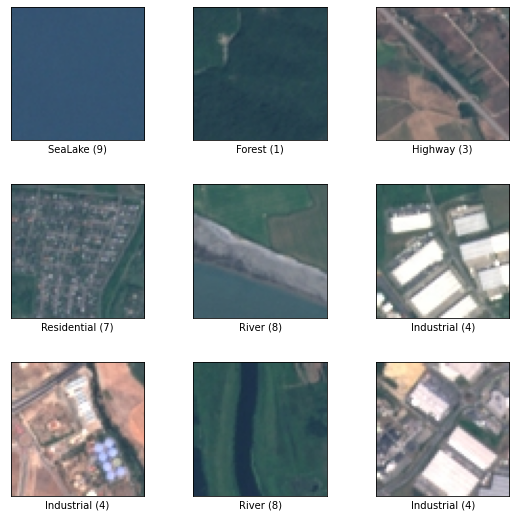

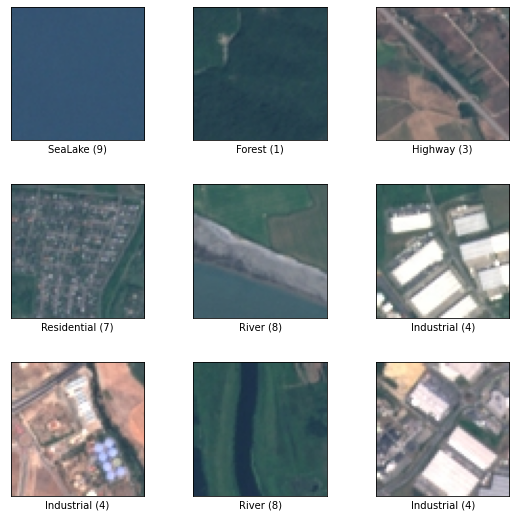

In [ ]:
tfds.show_examples(ds_train, info)

In [ ]:
def classnames_wkeys (name):
  return f"C: {name},  I: {info.features['label'].str2int(name)}"
  
[classnames_wkeys(name)for name in info.features['label'].names]

['C: AnnualCrop,  I: 0',
 'C: Forest,  I: 1',
 'C: HerbaceousVegetation,  I: 2',
 'C: Highway,  I: 3',
 'C: Industrial,  I: 4',
 'C: Pasture,  I: 5',
 'C: PermanentCrop,  I: 6',
 'C: Residential,  I: 7',
 'C: River,  I: 8',
 'C: SeaLake,  I: 9']

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
EUROSAT_CLASSES = len(info.features['label'].names)

for (image, label) in ds_train.take(1):
  INPUT_SHAPE = image.shape
  print(f'Input Shape: {INPUT_SHAPE}')

ds_train_size = ds_train.cardinality().numpy() * 0.7
X_train = ds_train.take(ds_train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
X_test = ds_train.skip(ds_train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

for ( img1, label1) in ds_train.take(1):
  print(label1)

Input Shape: (64, 64, 3)
tf.Tensor(9, shape=(), dtype=int64)


In [ ]:
eurosat_model = ResNet(layers=[3, 4, 6, 3], input_shape=INPUT_SHAPE, classes = EUROSAT_CLASSES)
eurosat_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['input_2[0][0]']                
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['resizing_1[0][0]']             
 D)                                                                                         

In [ ]:
early_stopping = EarlyStopping(patience=2, monitor='loss')
eurosat_model.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = eurosat_model.fit(X_train, batch_size=BATCH_SIZE, epochs=15, callbacks=[early_stopping])

Epoch 1/15
  3/296 [..............................] - ETA: 3:43:16 - loss: 4.2073 - accuracy: 0.1094